In [1]:
%load_ext autoreload
%autoreload 2
from utils import load_model
from argparse import Namespace
import pandas as pd
import numpy as np

from dataset.dataset import Temperatures
from dataset.utils import get_dataloader
from evaluation.utils import plot_predictions, get_auc_summary, get_summary_df

import matplotlib.pyplot as plt
import seaborn as sns
import torch

plt.style.use("science")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

plt.rcParams["text.latex.preamble"] = (
    "\\usepackage{lmodern} \\usepackage{times} \\usepackage{amssymb}"
)

/home/rob/miniconda3/envs/inps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the models
save_dirs = {
    "NP": "../saves/INPs_temperature/np_0",
    "INP_A": "../saves/INPs_temperature/inp_min_max_0",
    "INP_B": "../saves/INPs_temperature/inp_desc_0",
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    model_dict[model_name], config_dict[model_name] = load_model(
        save_dir, load_it="best"
    )
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

../saves/INPs_temperature/np_0
../saves/INPs_temperature/inp_min_max_0
../saves/INPs_temperature/inp_desc_0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/rob/miniconda3/envs/inps/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# Setup the dataloaders
config = Namespace(
    min_num_context=0,
    max_num_context=15,
    num_targets=288,
    noise=0,
    batch_size=32,
    x_sampler="random-uniform-15",
    test_num_z_samples=32,
    dataset="temperature",
    device="cuda:0",
)

dataset_a = Temperatures(
    root="../data/temperatures", split="test", knowledge_type="min_max"
)
data_loader_a = get_dataloader(dataset_a, config)

dataset_b = Temperatures(
    root="../data/temperatures", split="test", knowledge_type="desc"
)
data_loader_b = get_dataloader(dataset_b, config)

In [4]:
# Evaluate the models on different knowledge types
eval_type_ls = ["raw", "informed"]


def sampler(num_targets, num_context):
    samples = np.random.uniform(low=0, high=num_targets - 1, size=15)
    sample_idx = sorted(samples)
    return sample_idx


summary_a_df, losses_a, outputs_dict_a = get_summary_df(
    model_dict,
    config_dict,
    data_loader_a,
    eval_type_ls,
    ["NP", "INP_A"],
    sampler=sampler,
)

summary_b_df, losses_b, _ = get_summary_df(
    model_dict, config_dict, data_loader_b, eval_type_ls, ["INP_B"], sampler=sampler
)

summary_df = pd.concat([summary_a_df, summary_b_df])
losses = dict(**losses_a, **losses_b)

In [5]:
print_df = (
    summary_df.dropna(subset=["mean"])
    .pivot(
        columns="num_context",
        index=["model_name", "eval_type"],
        values=["mean"],
    )
    .T.round(2)
)
print_df = print_df.droplevel(0, axis=0).dropna(axis=1, how="all")
print_df

model_name     INP_A             INP_B                NP
eval_type   informed      raw informed      raw      raw
num_context                                             
0             489.14  3924.71   543.17  3572.96  2468.12
1             467.67   655.26   483.95   667.08   567.62
3             464.11   628.90   470.27   636.26   595.96
5             460.37   625.58   465.61   524.64   500.22
10            455.20   454.86   446.59   448.64   457.01
15            455.06   454.25   446.05   450.61   454.93

In [6]:
num_context_ls = [0, 1, 3, 5, 10, 15]

auc_df = pd.DataFrame()


def to_print(mean, error):
    return f"{mean:.1f}" + r" \scriptsize{(" + f"{error:.1f}" + r")}"


auc_sum_a, improvement_a = get_auc_summary(
    losses, "INP_A", ["informed"], num_context_ls
)
auc_sum_b, improvement_b = get_auc_summary(
    losses, "INP_B", ["informed"], num_context_ls
)

auc_a_df = (
    pd.concat(
        [
            pd.DataFrame(improvement_a["informed"]).T,
            pd.DataFrame(auc_sum_a["informed"]).T,
        ]
    )
    * 100
)
auc_a_df.columns = ["mean", "error"]
auc_a_df["col"] = num_context_ls + ["Delta AUC"]
auc_a_df["model_name"] = "A"

auc_b_df = (
    pd.concat(
        [
            pd.DataFrame(improvement_b["informed"]).T,
            pd.DataFrame(auc_sum_b["informed"]).T,
        ]
    )
    * 100
)
auc_b_df.columns = ["mean", "error"]
auc_b_df["col"] = num_context_ls + ["Delta AUC"]
auc_b_df["model_name"] = "B"

auc_df = pd.concat([auc_a_df, auc_b_df])
auc_df["print_val"] = auc_df.apply(lambda x: to_print(x["mean"], x["error"]), axis=1)
auc_df = auc_df.pivot(index="model_name", columns="col", values="print_val")
auc_df

col,0,1,3,5,10,15,Delta AUC
model_name,,,,,,,
A,66.2 \scriptsize{(1.7)},17.0 \scriptsize{(1.2)},16.3 \scriptsize{(1.1)},12.7 \scriptsize{(1.1)},-0.0 \scriptsize{(0.1)},-0.2 \scriptsize{(0.1)},22.8 \scriptsize{(1.0)}
B,57.8 \scriptsize{(3.0)},15.9 \scriptsize{(1.4)},12.5 \scriptsize{(1.3)},8.8 \scriptsize{(1.0)},0.4 \scriptsize{(0.1)},0.3 \scriptsize{(0.2)},20.1 \scriptsize{(0.9)}


In [7]:
# Plot sample predictions
for batch in data_loader_b:
    (x_context, y_context), (x_target, y_target), desc_knowledge, extras = batch
    x_context = x_context.to(config.device)
    y_context = y_context.to(config.device)
    x_target = x_target.to(config.device)
    y_target = y_target.to(config.device)
    pass

bs = y_target.shape[0]
min_max_knowledge = [
    torch.tensor([y_target[i, :, :].min(), y_target[i, :, :].max()]) for i in range(bs)
]

eval_types = ["raw", "min_max", "desc"]
outputs = {}
for eval_type in eval_types:
    if eval_type == "raw":
        model = model_dict["NP"]
        knowledge = None
    elif eval_type == "min_max":
        model = model_dict["INP_A"]
        knowledge = min_max_knowledge
    elif eval_type == "desc":
        model = model_dict["INP_B"]
        knowledge = desc_knowledge

    with torch.no_grad():
        outputs[eval_type] = model(
            x_context, y_context, x_target, y_target=y_target, knowledge=knowledge
        )

The night will start off chilly with temperatures around 1.7°C, decreasing slightly towards morning and then rising again to around 2.0°C by midday. Expect a colder afternoon and evening with temperatures dropping to near freezing point.
The night will start off cold with temperatures falling to -19.1°C, and the frigid weather will continue until the morning, reaching a low of -24.2°C. The afternoon will see a slight increase in temperature, but it will remain chilly, with temperatures dipping again to -21.5°C in the late evening.
The night will start off chilly with temperatures around 2 degrees, gradually dropping to around 1.3 degrees by early morning, but warming up to a high of 7.2 degrees in the afternoon. Expect a cooler evening with temperatures descending to around 4.7 degrees by midnight.


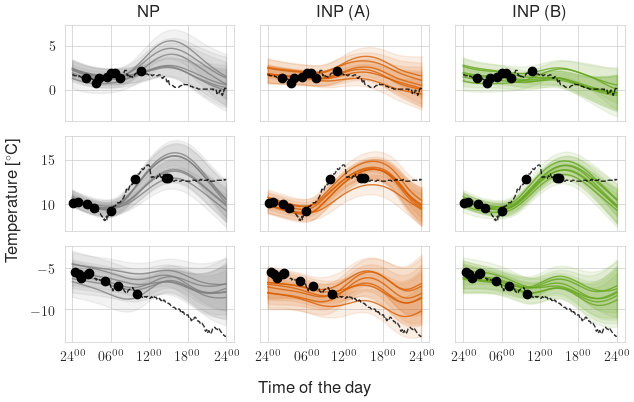

In [8]:
colors = {"raw": "grey", "min_max": "C1", "desc": "C4"}

fig, axs = plt.subplots(3, 3, figsize=(6.6, 4.2), sharex=True, sharey="row")

for i, eval_type in enumerate(eval_types):
    for j, in_batch_idx in enumerate([0, 4, 7]):
        if eval_type == "desc":
            print(knowledge[j])
        plot_predictions(
            axs[j][i],
            in_batch_idx,
            outputs[eval_type],
            x_context,
            y_context,
            x_target,
            extras,
            color=colors[eval_type],
            plot_true=True,
            num_z_samples=6,
        )

axs[1, 0].set_xticks([-2, -1, 0, 1, 2])
axs[1, 0].set_xticklabels(
    ["$24^{00}$", "$06^{00}$", "$12^{00}$", "$18^{00}$", "$24^{00}$"]
)
axs[0, 0].set_title("NP")
axs[0, 1].set_title("INP (A)")
axs[0, 2].set_title("INP (B)")

fig.supylabel("Temperature [$^\circ$C]", x=0.03)
fig.supxlabel("Time of the day", y=0.03)
plt.tight_layout()
# plt.savefig('../figures/temperature_predictions.pdf', bbox_inches='tight')
plt.show()